## Práctica 2: Limpieza y validación de los datos

In [105]:
import pandas as pd
import numpy as np
import datetime
from sklearn import preprocessing
from scipy.stats import anderson
from scipy.stats import fligner
from scipy import stats
from sklearn import linear_model
import matplotlib.pyplot as plt
from IPython.display import Image
import pickle
import requests
import geoplotlib
import time
import seaborn as sns

p = r'C:\Users\Administrador.WIN-K4PA08MDFCA\Documents\UOC\Ciclo de vida de los datos\Practica-1-Web-scraping\\'

### _1. Descripción del dataset. ¿Por qué es importante y qué pregunta/problema pretende responder?_

En esta práctica se intentará dar seguimiento a la primera práctica, por lo que se utilizará el Dataset creado en esta. 
El _dataset_ contiene un listado de todas las subastas judiciales y administrativas que ha habido en Catalunya desde 2016. Cada subasta contiene información sobre las normas que aplican a dicha subasta, los sujetos que participan y los bienes subastados. 

El objetivo del _dataset_ será: 
* Conocer donde está localizados los bienes subastados.
* Conocer precio de venta y los factores que más impactan en el mismo.

### _2. Integración y selección de los datos de interés a analizar._

La información de las subastas está contenida en 5 ficheros csv.
De los 5 ficheros para el primer análisis únicamente será necesario importar 3 de los ficheros, el que tiene información general de las subastas (infoSubastas), el que tiene información de los lotes subastados (lotesSubastas) y el de las pujas (pujasSubastas).

Los _datasets_ se pueden cruzar entre sí a través del campo codSubasta.

Importamos los datos y mostramos las columnas que tiene cada fichero y los primeros 3 registros:

#### 2.1 Importación de ficheros

* **InfoSubastas**: Contiene la información principal de las subastas y campos agregados del resto de ficheros.

In [2]:
pd.read_excel(p + "pdf/dataDictionary.xlsx", sheet_name="infoSubastas")

,Campo,Descripcion,Type,Formato,Ejemplo
0,codSubasta,código de la subasta.,str,NaN,SUB-JA-2016-3971
1,aut_Fax,Fax de la autoridad gestora de la subasta.,str,NaN,972219577
2,aut_Correo electrónico,Email de la autoridad gestora de la subasta.,str,NaN,-
3,Tipo de subasta,Tipo de subasta.,str,NaN,JUDICIAL EN VIA DE APREMIO
4,aut_Dirección,Dirección de la autoridad gestora de la subasta.,str,NaN,"AV RAMON FOLCH 4-6 4-6 , 17001 GIRONA"
5,aut_Código,Código de la autoridad gestora de la subasta.,int,NaN,1707942003
6,descripcion,Descripción de la subasta.,str,NaN,C. Doctor Fleming 9 2º 3ª DE Banyole
7,adm_NIF,NIF de la autoridad gestora de la subasta.,str,NaN,B55125827
8,Identificador,Identificador de la subasta. Es como el codSu...,str,NaN,SUB-JA-2016-39710
9,Expediente,NaN,str,NaN,1578/13


In [3]:
infoSubastas = pd.read_csv(p + "csv/infoSubastas.csv", sep=";",encoding='latin1')
infoSubastas.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,7,10,11,15,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,codSubasta,adm_Dirección,Anuncio BOE,Lotes,Puja mínima,aut_Teléfono,aut_Dirección,adm_Localidad,Scrap,aut_Correo electrónico,...,Tasación,estado,Tramos entre pujas,totPuja,acreedorPrivilegiado,Valor subasta,adm_Provincia,Forma adjudicación,Cantidad reclamada,Unnamed: 35
0,SUB-JA-2019-123877,NaN,BOE-B-2019-15328,2.0,0.0,934648605,"CL SANTA BARBARA 64 32 , 08911 BADALONA",NaN,True,mvcliment@xij.gencat.cat,...,0,Celebrándose,1669.7,0.0,NaN,166970.86,NaN,Separada para cada lote,"547.485,64 ",NaN
1,SUB-JA-2019-123010,NaN,BOE-B-2019-15356,0.0,Sin puja mínima,936938050,"PS VERDAGUER 113 113 , 08700 IGUALADA",NaN,True,mixt5.igualada@xij.gencat.cat,...,No consta,Celebrándose,"3.313,71 ",0.0,NaN,"165.685,92 ",NaN,NaN,"177.572,46 ",NaN
2,SUB-JA-2019-124079,NaN,BOE-B-2019-15624,0.0,Sin puja mínima,936932970,"RB PARE ALEGRE 112 342 , 08221 TERRASSA",NaN,True,bperezma@xij.gencat.cat,...,No consta,Celebrándose,"1.596,30 ",0.0,NaN,"79.815,00 ",NaN,NaN,"1,00 ",NaN


* **pujasSubastas**: Pujas realizadas para cada uno de los lotes y bienes de la subasta.

In [4]:
pd.read_excel(p + "pdf/dataDictionary.xlsx", sheet_name="pujasSubastas")

,Campo,Descripcion,Type,Formato,Ejemplo
0,codSubasta,Código de la subasta,str,NaN,SUB-JA-2019-123877
1,lote,Código del lote,int,NaN,1
2,Puja,Importe de la puja o indicado que no tiene puja,str,NaN,Sin puja


In [5]:
pujasSubastas = pd.read_csv(p + "csv/pujasSubastas.csv", sep=";",encoding='latin1',error_bad_lines=False)
pujasSubastas.head(3)

,codSubasta,lote,Puja,Unnamed: 3
0,SUB-JA-2019-123877,1,Sin puja,NaN
1,SUB-JA-2019-123877,2,Sin puja,NaN
2,SUB-JA-2019-123010,0,0,NaN


* **lotesSubastas**: Información de los lotes contenidos en cada una de las subastas.

In [6]:
pd.read_excel(p + "pdf/dataDictionary.xlsx", sheet_name="lotesSubastas")

,Campo,Descripcion,Type,Formato,Ejemplo
0,codSubasta,Código de la subasta,str,NaN,SUB-JA-2019-123877
1,lote,Código del lote,str,NaN,Lote 1
2,Número de bastidor,Número de bastidor del vehículo,str,NaN,U5YHN511AFL193544
3,Localidad,Localidad del bien,str,NaN,L'HOSPITALET DE LLOBREGAT
4,Valor Subasta,Valor de subasta del lote,float,NaN,83485.4
5,Puja mínima,Púja mínima del lote,float,NaN,Sin puja mínima
6,Referencia Registral,Referencia catastral del bien inmueble,str,NaN,20160001228
7,Cuota,NaN,int,NaN,66
8,Información adicional,NaN,str,NaN,INSCRITA en el Registro de la Propiedad de Gav...
9,IDUFIR,Código IDUFIR del edificio,str,NaN,8086000327226


In [7]:
lotesSubastas = pd.read_csv(p + "csv/lotesSubastas.csv", sep=";",encoding='latin1',error_bad_lines=False)
lotesSubastas.head(3)

b'Skipping line 15973: expected 33 fields, saw 36\n'
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,codSubasta,lote,Número de bastidor,Localidad,Valor Subasta,Puja mínima,Referencia Registral,Cuota,Información adicional,IDUFIR,...,Visitable,Dirección,Valor de tasación,numBienes,Tramos entre pujas,Provincia,Código Postal,Depósito,Cantidad reclamada,Unnamed: 32
0,SUB-JA-2019-123877,Lote 1,NaN,L'HOSPITALET DE LLOBREGAT,"83.485,43 ",Sin puja mínima,NaN,NaN,NaN,NaN,...,No consta,MOSSEN JAUME BUSQUETS 37. PLANTA PRINCIPAL PUE...,NaN,1.0,"1.669,70 ",Barcelona,8903.0,NaN,NaN,NaN
1,SUB-JA-2019-123877,Lote 2,NaN,L'HOSPITALET DE LLOBREGAT,"83.485,43 ",Sin puja mínima,NaN,NaN,NaN,NaN,...,No consta,"MOSSEN JAUME BUSQUESTS, 37, PLANTA 2ª PUERTA 2ª",NaN,1.0,"1.669,70 ",Barcelona,8903.0,NaN,NaN,NaN
2,SUB-JA-2019-123010,Lote 1,NaN,Vilanova del Camí,NaN,Sin puja mínima,NaN,NaN,NaN,NaN,...,No consta,"calle Mayor, 14",No consta,NaN,"3.313,71 ",Barcelona,8788.0,NaN,NaN,NaN


#### 2.2 Selección de datos de interés

Únicamente seleccionaremos las subastas de bienes inmuebles. Para ello:

* Descartamos los registros con número de bastidor, son vehículos:

In [8]:
print("¿Número bastidos informado?")
lotesSubastas.pivot_table(values="codSubasta",index=[lotesSubastas["Número de bastidor"].isnull()==False],aggfunc="count")

¿Número bastidos informado?


,codSubasta
Número de bastidor,
False,29233
True,122


* Descartamos los registros sin dirección. Según la información adicional se trata de participaciones en empresas

In [9]:
print("¿Dirección informada?")
lotesSubastas.pivot_table(values="codSubasta",index=[lotesSubastas["Dirección"].isnull()==False],aggfunc="count")

¿Dirección informada?


,codSubasta
Dirección,
False,626
True,28729


In [10]:
lotesSubastas = lotesSubastas[lotesSubastas["Dirección"].isnull()==False & lotesSubastas["Número de bastidor"].isnull()]
infoSubastas = infoSubastas[infoSubastas["codSubasta"].isin(lotesSubastas['codSubasta'])]
pujasSubastas = pujasSubastas[pujasSubastas["codSubasta"].isin(pujasSubastas['codSubasta'])]
print("Número de subastas final: %d"%(len(lotesSubastas)))

Número de subastas final: 28729


#### 2.3 Integración de los datos

La unión de los _dataset_ se deja para el final de la limpieza, ya que durante el proceso algunos factores pueden ser descartados o sustituidos por otros.

Por ejemplo, el valor de la subasta se deberá analizar si es mejor utilizando agregado a nivel subasta o desagregado por lote.

### _3. Limpieza de los datos._

#### _3.1. ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?_


El _dataset_ contiene multiples campos con ceros o vacíos. Por lo que hacemos un primer análisis de la tabla identificando ceros y valores nulos. 
Luego analizamos campo a campo cada uno de los 3 _datasets_ aplicando la corrección correspondiente.

In [11]:
for col in infoSubastas.columns:
    if type(infoSubastas[col][1])==str:
        print("El campo %s, de tipo str, tiene %d nulos"%(col,len(infoSubastas[infoSubastas[col].isnull()])))
    else:
        print("El campo %s, de tipo numeric, tiene %d nulos y %d ceros"%(col,len(infoSubastas[infoSubastas[col].isnull()]),len(infoSubastas[infoSubastas[col]==0])))

El campo codSubasta, de tipo str, tiene 0 nulos
El campo adm_Dirección, de tipo numeric, tiene 15949 nulos y 0 ceros
El campo Anuncio BOE, de tipo str, tiene 0 nulos
El campo Lotes, de tipo numeric, tiene 0 nulos y 13531 ceros
El campo Puja mínima, de tipo str, tiene 0 nulos
El campo aut_Teléfono, de tipo str, tiene 0 nulos
El campo aut_Dirección, de tipo str, tiene 0 nulos
El campo adm_Localidad, de tipo numeric, tiene 15949 nulos y 0 ceros
El campo Scrap, de tipo numeric, tiene 0 nulos y 0 ceros
El campo aut_Correo electrónico, de tipo str, tiene 0 nulos
El campo adm_Nombre, de tipo numeric, tiene 15949 nulos y 0 ceros
El campo aut_Código, de tipo str, tiene 0 nulos
El campo aut_Fax, de tipo str, tiene 0 nulos
El campo link, de tipo str, tiene 0 nulos
El campo descripcion, de tipo str, tiene 5 nulos
El campo adm_NIF, de tipo numeric, tiene 15949 nulos y 0 ceros
El campo Identificador, de tipo str, tiene 0 nulos
El campo Fecha de conclusión, de tipo str, tiene 1682 nulos
El campo Impo

* **Acreedor privilegiado**: En caso de acreedor prilegiado diferente a True consideramos que el False.

In [12]:
infoSubastas['acreedorPrivilegiado'].loc[infoSubastas['acreedorPrivilegiado']!=True] = False

* **Lotes**: Es el número de lotes de cada subastas, y tiene muchos valores igual a 0. El valor igual a 0 significa que no es por lotes, ya que solo tiene uno. Modificamos los valores por 1

In [13]:
infoSubastas["Lotes"].loc[infoSubastas.Lotes==0] = 1
infoSubastas.groupby("Lotes")['Lotes'].count()[:10]

Lotes
1.0     13531
2.0      1276
3.0       387
4.0       207
5.0       112
6.0        74
7.0        58
8.0        52
9.0        44
10.0       28
Name: Lotes, dtype: int64

* **Puja mínima**: En muchas subastas no existe puja mínima. En estos casos el valor que está tomando es "Sin puja mínima". Se debe convertir el campo a numérico pasando los valores sin puja a nulos. Ya que el importe no existe, no es ni desconocido ni cero.

In [14]:
# infoSubastas['Puja mínima'] = infoSubastas['Puja mínima'].map(lambda:if float)
def cleanPujaMin(pujaMin):
    if type(pujaMin) == float:
        return pujaMin
    if type(pujaMin) == int:
        return float(pujaMin)
    elif (pujaMin in ['Sin puja mínima','No consta']):
        return np.nan
    else:
        return float(pujaMin.replace(" \x80","").replace(".","").replace(",","."))
    
infoSubastas['Puja mínima'] = infoSubastas['Puja mínima'].map(cleanPujaMin)

Eliminamos los que supere el quartile 95, con el objetivo de ver mejor los valores no extremos


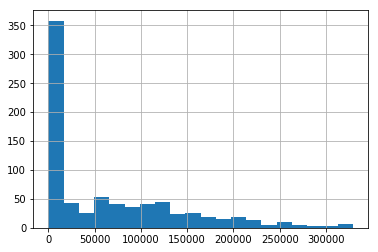

In [15]:
print("Eliminamos los que supere el quartile 95, con el objetivo de ver mejor los valores no extremos")
infoSubastas[(infoSubastas['Puja mínima'] > 0.0) & (infoSubastas['Puja mínima']<infoSubastas['Puja mínima'].quantile(0.95))]['Puja mínima'].hist(bins=20)

* **Importe del depósito**: Tiene formato alfanumérico. Se le modifica el formato a numérico y en caso de nulos, se le mantiene, ya que podría no haber importe de depósito.

In [16]:
def cleanImporDep(imporDep):
    if type(imporDep)==float:
        return imporDep
    elif "," not in imporDep:
        return float(imporDep)
    else:
        try:
            return float(imporDep.replace(" \x80","").replace(".","").replace(",","."))
        except:
            return np.NaN
    
infoSubastas['Importe del depósito'] = infoSubastas['Importe del depósito'].map(cleanImporDep)

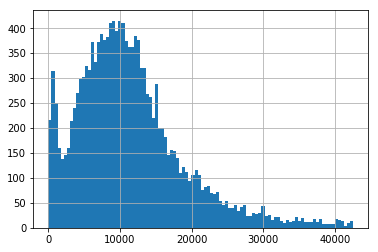

In [17]:
infoSubastas['Importe del depósito'][(0<infoSubastas['Importe del depósito']) & (infoSubastas['Importe del depósito']<infoSubastas['Importe del depósito'].quantile(0.95))].hist(bins=100)

* **totPujas**: Revisamos que no haya valores nulos en el total de las pujas

In [18]:
infoSubastas.pivot_table(values="totPuja", index=[infoSubastas["totPuja"]>0], aggfunc=["count","sum","mean"])

,count,sum,mean
,totPuja,totPuja,totPuja
totPuja,,,
False,12938,0.0,0.000000
True,3129,498578831.3,159341.269191


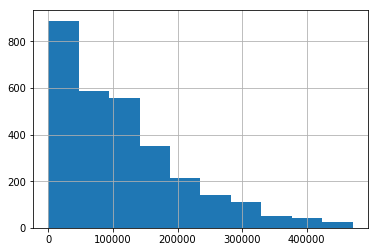

In [19]:
infoSubastas["totPuja"][(infoSubastas["totPuja"]>0) & (infoSubastas["totPuja"] < infoSubastas["totPuja"].quantile(0.99))].hist()

* **Tasación**: Convertimos la tasación en aquellos casos en los que no sea nulo a numérico. Cuando indica 'No consta' lo convertimos a vacío ya que no existe.

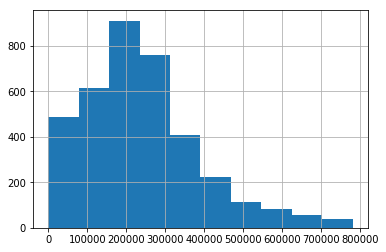

In [20]:
def cleanTasacion(tasacion):
    if type(tasacion)==float:
        return tasacion
    elif tasacion=="No consta":
        return None
    elif "," not in tasacion:
        return float(tasacion)
    else:
        return float(tasacion.replace(" \x80","").replace(".","").replace(",","."))
    
infoSubastas["Tasación"] = infoSubastas["Tasación"].map(cleanTasacion)

infoSubastas["Tasación"].where((infoSubastas["Tasación"]>0) & (infoSubastas["Tasación"]<infoSubastas["Tasación"].quantile(0.95))).hist()

* **Tramos**: Tramos entre subastas. Lo convertimos a numérico y si indica "Sin tramo" lo pasamos a vacío.

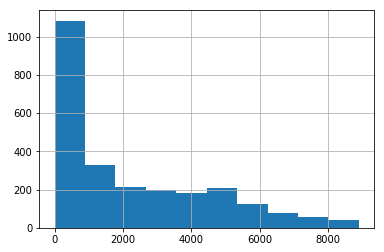

In [21]:
def cleanTramos(tramos):
    if type(tramos)==float:
        return tramos
    elif tramos=="Sin tramos":
        return None
    elif "," not in tramos:
        return float(tramos)
    else:
        return float(tramos.replace(" \x80","").replace(".","").replace(",","."))
    
infoSubastas["Tramos entre pujas"] = infoSubastas["Tramos entre pujas"].map(cleanTramos)
infoSubastas["Tramos entre pujas"].where((infoSubastas["Tramos entre pujas"]>0) & (infoSubastas["Tramos entre pujas"]<infoSubastas["Tramos entre pujas"].quantile(0.95))).hist()

* **Valor subasta**: Valor de la subastas. Lo convertimos a numérico y si indica "No consta" lo pasamos a vacío.

In [22]:
print("¿Valor de la subasta nulo?")
infoSubastas.pivot_table(values="codSubasta", index=[infoSubastas["Valor subasta"]=='No consta'], aggfunc="count")

¿Valor de la subasta nulo?


,codSubasta
Valor subasta,
False,16056
True,13


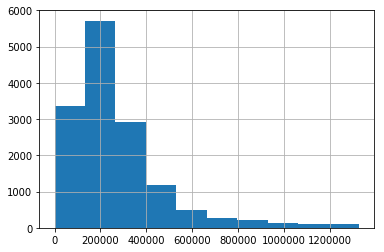

In [23]:
def cleanValorSub(tramos):
    if type(tramos)==float:
        return tramos
    elif tramos=="No consta":
        return None
    elif "," not in tramos:
        return float(tramos)
    else:
        return float(tramos.replace(" \x80","").replace(".","").replace(",","."))
    
infoSubastas["Valor subasta"] = infoSubastas["Valor subasta"].map(cleanValorSub)
infoSubastas["Valor subasta"].where((infoSubastas["Valor subasta"]>0) & (infoSubastas["Valor subasta"]<infoSubastas["Valor subasta"].quantile(0.95))).hist()

* **Cantidad Reclamada**: Cantidad total reclamada al acreedor. Lo convertimos a numérico y si indica "No consta" lo pasamos a vacío.

In [24]:
print("¿Valor de la cantidad reclamada igual a null?")
infoSubastas.pivot_table(values="Cantidad reclamada", index=[infoSubastas["Cantidad reclamada"].isnull()], aggfunc="count")

¿Valor de la cantidad reclamada igual a null?


,Cantidad reclamada
Cantidad reclamada,
False,15996
True,0


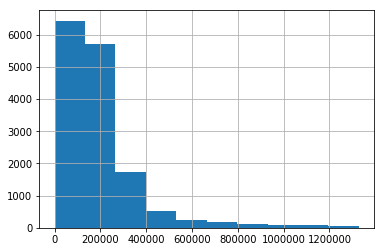

In [25]:
def cleanCantidadReclamada(reclamado):
    if type(reclamado)==float:
        return reclamado
#     elif tramos=="No consta":
#         return None
    elif "," not in reclamado:
        return float(reclamado)
    else:
        return float(reclamado.replace(" \x80","").replace(".","").replace(",","."))
    
infoSubastas["Cantidad reclamada"] = infoSubastas["Cantidad reclamada"].map(cleanCantidadReclamada)
infoSubastas["Cantidad reclamada"].where((infoSubastas["Cantidad reclamada"]>0) & (infoSubastas["Cantidad reclamada"]<infoSubastas["Cantidad reclamada"].quantile(0.95))).hist()

* **Fechas**: Revisamos las fecha de conclusión de la subasta y de inicio de la subasta. Antes de nada debemos cambiar el formato a fecha.
Revismos las fechas de inicio nulas porque no deberían existir

In [26]:
infoSubastas['dateConclusion'] = infoSubastas["Fecha de conclusión"].map(lambda x: x if type(x)==float else datetime.datetime.strptime(x[0:19],"%d-%m-%Y %H:%M:%S").date())
infoSubastas['monthConclusion'] = infoSubastas['Fecha de conclusión'].map(lambda x: x.month if type(x) == datetime.date else np.nan)
infoSubastas['yearConclusion'] = infoSubastas['Fecha de conclusión'].map(lambda x: x.year if type(x) == datetime.date else np.nan)

infoSubastas['dateInicio'] = infoSubastas["Fecha de inicio"].map(lambda x: x if type(x)==float else datetime.datetime.strptime(x[0:19],"%d-%m-%Y %H:%M:%S").date())
infoSubastas['monthInicio'] = infoSubastas['dateInicio'].map(lambda x: x.month if type(x) == datetime.date else np.nan)
infoSubastas['yearInicio'] = infoSubastas['dateInicio'].map(lambda x: x.year if type(x) == datetime.date else np.nan)

In [27]:
print("Se identifican %d subastas con fecha de inicio nulo."%len(infoSubastas[infoSubastas["Fecha de inicio"].map(type)==float]))
# infoSubastas[infoSubastas["Fecha de inicio"].map(type)==float][["codSubasta", 'link']]

Se identifican 1682 subastas con fecha de inicio nulo.


 Se comprueba que son subastas canceladas, y que es esta la razón de la falta del dato. Lo comprobamos:

In [28]:
infoSubastas.pivot_table(values="codSubasta",columns=[infoSubastas["Fecha de inicio"].map(type)!=float], index='estado', aggfunc="count")

Fecha de inicio,False,True
estado,,
Cancelad,1663.0,NaN
Celebrándose,NaN,289.0
Concluida,NaN,1955.0
Finalizada,NaN,12143.0
Suspendid,19.0,NaN


Analizamos si hay entre las subastas canceladas o suspendidas alguna puja. 

Conclusión, no. Las subastas canceladas o susdidas deberán descartarse del analisis en caso de querer predecir el precio de la última puja. 

Pueden ser útiles para colocarlos en un mapa y ver por donde hay más número de bienes embargados.

In [29]:
infoSubastas.pivot_table(values="codSubasta",columns= [infoSubastas["totPuja"]>0], index='estado',aggfunc="count")

totPuja,False,True
estado,,
Cancelad,1663.0,NaN
Celebrándose,288.0,1.0
Concluida,417.0,1538.0
Finalizada,10553.0,1590.0
Suspendid,19.0,NaN


Analizamos la distribución de la fecha de inicio por año y mes:

In [30]:
infoSubastas.pivot_table(values="codSubasta",index="monthInicio",columns='yearInicio',aggfunc="count")

yearInicio,2015.0,2016.0,2017.0,2018.0,2019.0
monthInicio,,,,,
1.0,NaN,16.0,475.0,335.0,231.0
2.0,NaN,84.0,559.0,425.0,296.0
3.0,NaN,230.0,544.0,408.0,334.0
4.0,NaN,230.0,372.0,309.0,183.0
5.0,NaN,381.0,424.0,419.0,NaN
6.0,NaN,579.0,509.0,406.0,NaN
7.0,NaN,257.0,253.0,203.0,NaN
8.0,NaN,71.0,53.0,88.0,NaN
9.0,NaN,569.0,474.0,335.0,NaN


#### Limpieza de lotes subastas

In [31]:
for col in lotesSubastas.columns:
    if type(lotesSubastas[col][1])==str:
        print("El campo %s, de tipo str, tiene %d nulos"%(col,len(lotesSubastas[lotesSubastas[col].isnull()])))
    else:
        print("El campo %s, de tipo numeric, tiene %d nulos y %d ceros"%(col,len(lotesSubastas[lotesSubastas[col].isnull()]),len(lotesSubastas[lotesSubastas[col]==0])))

El campo codSubasta, de tipo str, tiene 0 nulos
El campo lote, de tipo str, tiene 0 nulos
El campo Número de bastidor, de tipo numeric, tiene 28729 nulos y 0 ceros
El campo Localidad, de tipo str, tiene 15 nulos
El campo Valor Subasta, de tipo str, tiene 17286 nulos
El campo Puja mínima, de tipo str, tiene 3213 nulos
El campo Referencia Registral, de tipo numeric, tiene 28729 nulos y 0 ceros
El campo Cuota, de tipo numeric, tiene 28721 nulos y 0 ceros
El campo Información adicional, de tipo numeric, tiene 26071 nulos y 0 ceros
El campo IDUFIR, de tipo numeric, tiene 20304 nulos y 30 ceros
El campo Título jurídico, de tipo numeric, tiene 28332 nulos y 0 ceros
El campo Descripción, de tipo str, tiene 0 nulos
El campo Modelo, de tipo numeric, tiene 28727 nulos y 0 ceros
El campo Fecha de adquisición, de tipo numeric, tiene 28727 nulos y 0 ceros
El campo Fecha de matriculación, de tipo numeric, tiene 28729 nulos y 0 ceros
El campo Inscripción registral, de tipo str, tiene 18080 nulos
El ca

In [32]:
print('Corregimos los factores numéricos')
lotesSubastas['Valor Subasta'] = lotesSubastas['Valor Subasta'].map(cleanValorSub)
lotesSubastas['Puja mínima'] = lotesSubastas['Puja mínima'].map(cleanPujaMin)
lotesSubastas['Importe del depósito'] = lotesSubastas['Importe del depósito'].map(cleanImporDep)
lotesSubastas['Valor de tasación'] = lotesSubastas['Valor de tasación'].map(cleanTasacion)


Corregimos los factores numéricos


Analizamos el campo Vivienda habitual.

In [33]:
lotesSubastas.pivot_table(values="codSubasta", index=['Vivienda habitual'], aggfunc="count")

,codSubasta
Vivienda habitual,
"13.320,25 ",1
"7.774,00 ",1
No,10821
Sí,4725


Eliminamos los registros que tienen como vivienda habitual un importe. Son errores del _dataset_.

In [34]:
lotesSubastas = lotesSubastas[(lotesSubastas["Vivienda habitual"].isin(["Sí", "No"])) | (lotesSubastas["Vivienda habitual"].isnull())]
infoSubastas = infoSubastas[infoSubastas["codSubasta"].isin(lotesSubastas['codSubasta'])]
pujasSubastas = pujasSubastas[pujasSubastas["codSubasta"].isin(pujasSubastas['codSubasta'])]
print("Número de subastas final: %d"%(len(lotesSubastas)))

Número de subastas final: 28727


Los tipo  subasta igual a NaN los pasamos a desconocido.

In [35]:
lotesSubastas["Vivienda habitual"][lotesSubastas["Vivienda habitual"].isin(["Sí", "No"])==False] = "Desconocido"

In [36]:
lotesSubastas.pivot_table(values="codSubasta", index=['Vivienda habitual'], aggfunc="count")

,codSubasta
Vivienda habitual,
Desconocido,13181
No,10821
Sí,4725


Corregimos el campo Visitable, dejandolo en las opciones 'Sí', 'No'.

In [37]:
lotesSubastas['Visitable'] = lotesSubastas['Visitable'].map(lambda x: x[:2])

#### Limpieza de pujas subastas

In [38]:
pujasSubastas["lote"].loc[pujasSubastas.lote==0] = 1
pujasSubastas.groupby(pujasSubastas["lote"]).count()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,codSubasta,Puja,Unnamed: 3
lote,,,
1,16565,16565,0
2,1732,1732,0
3,926,926,0
4,640,640,0
5,496,496,0
6,417,417,0
7,368,368,0
8,325,325,0
9,285,285,0


In [39]:
def cleanPujas(puja):
    if type(puja)==float:
        return puja
    elif (puja in ['Sin puja','No consta', 'Cancelado', 'Con puja (inicie sesión para consultar el importe)']):
        return np.nan
    else:
        return float(puja.replace(" \x80","").replace(".","").replace(",","."))
    
    
pujasSubastas['Puja'] = pujasSubastas['Puja'].map(cleanPujas)

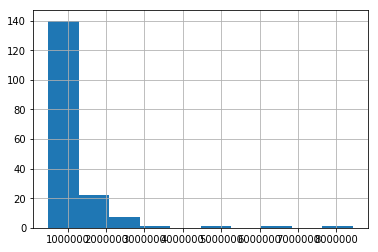

In [40]:
pujasSubastas[(pujasSubastas['Puja']>0) & (500000<pujasSubastas['Puja'])]['Puja'].hist()

#### _3.2. Identificación y tratamiento de valores extremos._

Al corregir las variables numéricas como el valor de la subasta, hemos podido comprobar que existen valores extremos que deberán ser analizados.

Para empezar marcaremos las subastas que tienen valores extremos en alguno de estos factores, para ver si son siempre los mismos.

In [41]:
def valorExtremo(col):
    infoSubastas["exc_" + col] = (infoSubastas[col]>=infoSubastas[col].quantile(0.95))
    
valorExtremo("totPuja")
valorExtremo("Puja mínima")
valorExtremo("Importe del depósito")
valorExtremo("Tasación")
valorExtremo("Tramos entre pujas")
valorExtremo("Valor subasta")
valorExtremo("Cantidad reclamada")

Revisamos si los valores extremos son están concentrados en subastas con varios lotes.

In [42]:
infoSubastas.pivot_table(values="codSubasta",index="Lotes",columns='exc_Valor subasta',aggfunc="count")

exc_Valor subasta,False,True
Lotes,,
1.0,13139.0,390.0
2.0,1215.0,61.0
3.0,345.0,42.0
4.0,178.0,29.0
5.0,81.0,31.0
6.0,62.0,12.0
7.0,44.0,14.0
8.0,37.0,15.0
9.0,28.0,16.0


**Conclusión**, sí. El únicamente el 48% de los valores extremos tienen un solo lote mientras que los valores nomales tienen en alrededor del 80% de los casos un solo lote.

Analizamos la correlación entre estar en el 5% más alto en los diferentes valores.

In [43]:
infoSubastas[[col for col in infoSubastas.columns if col.find("exc_")==0]].corr()

,exc_totPuja,exc_Puja mínima,exc_Importe del depósito,exc_Tasación,exc_Tramos entre pujas,exc_Valor subasta,exc_Cantidad reclamada
exc_totPuja,1.000000,0.002253,0.142409,0.063884,0.072930,0.083605,0.053766
exc_Puja mínima,0.002253,1.000000,0.118695,0.248160,0.058960,0.161420,0.119092
exc_Importe del depósito,0.142409,0.118695,1.000000,0.324529,0.209423,0.589293,0.304433
exc_Tasación,0.063884,0.248160,0.324529,1.000000,0.069014,0.343538,0.216772
exc_Tramos entre pujas,0.072930,0.058960,0.209423,0.069014,1.000000,0.148359,0.082679
exc_Valor subasta,0.083605,0.161420,0.589293,0.343538,0.148359,1.000000,0.541049
exc_Cantidad reclamada,0.053766,0.119092,0.304433,0.216772,0.082679,0.541049,1.000000


**Conclusión**, cuando el valor de la subasta toma un valor extremo también suele hacerlo la cantidad reclamada y el importe del depósito.

No considero que los importes del _dataset_ infoSubastas deban ser eliminados o capados.

Se analiza el _dataset_ pujasSubastas, donde si parece que puede ser necesario eliminar los valores extremos, por ejemplo el de 8.000.000€ que es un hotel en Barcelona centro. 

El porcentaje de pujas mayores de 1.000.000€ es de 0.989299%


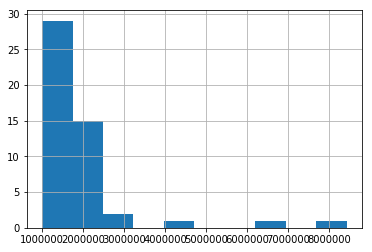

In [44]:
print("El porcentaje de pujas mayores de 1.000.000€ es de %f%%"%(100*(pujasSubastas["Puja"]>1000000).sum()/(pujasSubastas["Puja"]>0).sum()))
pujasSubastas[pujasSubastas["Puja"]>1000000]["Puja"].hist()

Eliminamos las subastas con pujas superiores al 1.000.000. Por unas comprobaciones hechas, se trata de edificios enteros sin división horizontal con uso de hotel, almacen o uso industrial.

In [45]:
extrem_pujas = pujasSubastas[pujasSubastas["Puja"]>1000000]["codSubasta"]

lotesSubastas = lotesSubastas[lotesSubastas["codSubasta"].isin(extrem_pujas)==False]
infoSubastas = infoSubastas[infoSubastas["codSubasta"].isin(extrem_pujas)==False]
pujasSubastas = pujasSubastas[pujasSubastas["codSubasta"].isin(extrem_pujas)==False]
print("Número de subastas final: %d"%(len(lotesSubastas)))

Número de subastas final: 28622


### _4. Análisis de los datos._

#### _4.1. Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar)._

Arreglamos la variable primario lote del _dataset_ _pujasSubastas_ para que se pueda cruzar con _lotesSubastas_.


In [46]:
pujasSubastas["numLote"] = pujasSubastas["lote"]
pujasSubastas["lote"] = pujasSubastas["lote"].map(lambda x: "Lote "+str(x))

Unimos las tablas quedandonos únicamente con los factores que queremos meter dentro del análisis.

In [47]:
colLotes=['codSubasta','lote','Localidad','Valor Subasta','Puja mínima','Vivienda habitual','Referencia catastral',
          'Situación posesoria','Importe del depósito','Visitable','Dirección','Valor de tasación','numBienes',
          'Tramos entre pujas', 'Provincia', 'Código Postal']
colPujas=["codSubasta","lote","Puja"]
colInfo=['codSubasta', 'Lotes', 'adm_Localidad','Tipo de subasta', 'numInteresados', 'numAcreedores',
         'autoridad', 'Tasación', 'estado', 'Tramos entre pujas','acreedorPrivilegiado', 'adm_Provincia',
         'Forma adjudicación','Cantidad reclamada','monthConclusion', 'yearConclusion','monthInicio', 'yearInicio']

bdFinal = pd.merge(lotesSubastas[colLotes], pujasSubastas[colPujas],how='left',left_on=["codSubasta","lote"],right_on=["codSubasta","lote"])
bdFinal = pd.merge(bdFinal, infoSubastas[colInfo],how='inner',left_on=["codSubasta"],right_on=["codSubasta"])

Se crean nuevos campos a través de los factores existentes:

* **Referencia catastral**: Si tiene una longitud de 14 caracteres significa que es una parcela entera, luego un potencial edificio sin división horizontal, en caso de ser de 19 es un inmueble dentro de una parcela.

In [48]:
def tipoRef(ref):
    if type(ref)!=str:
        return "Desconocido"
    elif len(ref)==14:
        return "Parcela"
    elif len(ref)==20:
        return "Inmueble"
    else:
        return "Desconocido"
    
bdFinal["tipoRef"] = bdFinal['Referencia catastral'].map(tipoRef)
bdFinal.pivot_table(values="codSubasta",index="tipoRef",aggfunc="count")



,codSubasta
tipoRef,
Desconocido,21839
Inmueble,8819
Parcela,176


In [49]:
del bdFinal['Referencia catastral']

* **Estado**: Si NaN entonces desconocido.

In [50]:
bdFinal['estado'][bdFinal['estado'].isnull()]="Desconocido"
bdFinal.groupby('estado')['codSubasta'].count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


estado
Cancelad         3818
Celebrándose      738
Concluida        4327
Finalizada      21874
Suspendid          77
Name: codSubasta, dtype: int64

* **Autoridad**: Transformamos el campo autoridad a tipoAutoridad para analizar únicamente aquellas instancias más comunes.

In [51]:
def tipoAutoridad(autoridad):
    if type(autoridad)!=str:
        return "Otros"
    else:
        autoridad = autoridad.upper()
        
    if autoridad.find('JUZGADO 1ª INST')!=-1:
        return 'JUZGADO 1ª INST'    
    if autoridad.find('JUZGADO')!=-1:
        return 'OTROS JUZGADOS'    
    elif autoridad.find('NOTARÍA')!=-1:
        return 'Notaría'
#     elif autoridad.find('SUBASTAS')!=-1:
#         return 'SUBASTAS'
#     elif autoridad.find('CONSELL COMARCAL')!=-1:
#         return 'CONSELL COMARCAL'
#     elif autoridad.find('AUDIENCIA PROV')!=-1:
#         return 'AUDIENCIA PROV'
#     elif autoridad.find('CONSELL COMARCAL')!=-1:
#         return 'CONSELL COMARCAL'
#     elif autoridad.find('AUDIENCIA NACIONAL')!=-1:
#         return 'AUDIENCIA NACIONAL'
    else:
        return "Otros"
bdFinal["tipoAutor"] = bdFinal["autoridad"].map(tipoAutoridad)
del bdFinal["autoridad"]

In [52]:
bdFinal.pivot_table(values="codSubasta", index="tipoAutor", aggfunc="count")

,codSubasta
tipoAutor,
JUZGADO 1ª INST,24021
Notaría,1022
OTROS JUZGADOS,5686
Otros,105


* **Provincia**: Transformamos el campo provincia, marcando como resto aquellas que no estén en Caalunya.

In [53]:
def fmtProvincia(provincia):
    if type(provincia)!=str:
        return "Otros"
    else:
        provincia = provincia.upper()
        
    if provincia.find('BARCELONA')!=-1:
        return 'BARCELONA'    
    if provincia.find('TARRAGONA')!=-1:
        return 'TARRAGONA'    
    elif provincia.find('GERONA')!=-1:
        return 'GERONA'
    elif provincia.find('LERIDA')!=-1:
        return 'LERIDA'
    else:
        return "Otros"
bdFinal['Provincia'] = bdFinal['Provincia'].map(fmtProvincia)

In [54]:
bdFinal.pivot_table(values="codSubasta", index='Provincia', aggfunc="count")

,codSubasta
Provincia,
BARCELONA,16090
GERONA,5002
Otros,3682
TARRAGONA,6060


* **Situación posesoria**: Transformamos el campo provincia, marcando como resto aquellas que no estén en Caalunya.

In [55]:
def corrSitPos(sitPos):
    if type(sitPos)!=str:
        return "Otros"
    else:
        sitPos = sitPos.upper()
        
    if sitPos.find('NO CONSTA')!=-1:
        return 'No consta'    
    if sitPos.find('OCUPANTES CON DERECHO')!=-1:
        return 'Ocupantes con derecho'    
    elif sitPos.find('OCUPANTES SIN DERECHO')!=-1:
        return 'Ocupantes sin derecho'
    elif sitPos.find('SIN OCUPANTES')!=-1:
        return 'Sin ocupantes'
    else:
        return "Otros"

col="Situación posesoria"
bdFinal[col] = bdFinal[col].map(corrSitPos)

In [56]:
bdFinal.pivot_table(values="codSubasta", index=col, aggfunc="count")

,codSubasta
Situación posesoria,
No consta,25200
Ocupantes con derecho,807
Ocupantes sin derecho,552
Otros,66
Sin ocupantes,4209


* **Tipo subasta**: Corregimos y eliminamos los campos nulos del factor tipo subasta.

In [57]:
def corrTipoSub(tipoSub):
    if type(tipoSub)!=str:
        return "Otros"
    else:
        tipoSub = tipoSub.upper()
        
    if tipoSub in ["JUDICIAL EN VIA DE APREMIO",'JUDICIAL CONCURSAL','JUDICIAL VOLUNTARIA']:
        return tipoSub    
    if tipoSub.find('NOTARIA')!=-1:
        return 'NOTARIAL'
    else:
        return "Otros"

col='Tipo de subasta'
bdFinal[col] = bdFinal[col].map(corrTipoSub)


In [58]:
bdFinal.pivot_table(values="codSubasta", index=col, aggfunc="count")



,codSubasta
Tipo de subasta,
JUDICIAL CONCURSAL,1092
JUDICIAL EN VIA DE APREMIO,24416
JUDICIAL VOLUNTARIA,4243
NOTARIAL,1022
Otros,61


* **Hay puja**: Creamos una variable que servirá como respuesta, que indica si ha habido puja máxima o no.

In [59]:
bdFinal["isPuja"] = bdFinal["Puja"].map(lambda x: 1 if x>0 else 0)

**Convertimos en numéricas las variables categóricas**

Primero dividiremos los factores en:
- IDs
- Numéricos
- Categóricos

In [60]:
def typCol(col):
    a = bdFinal[col].dropna().reset_index(drop=True)
    if len(a)>0:
        if type(a[0])==str:
            return str
        else:
            return float
    else:
        return None

colResp = ["Puja", "isPuja"]
colID = ["codSubasta", 'lote', 'estado', 'Forma adjudicación', 'Valor Subasta', 'Código Postal', "Dirección"]
colCat = ["Situación posesoria", 'Visitable','Provincia', 'Tipo de subasta', 'tipoRef', 'tipoAutor', 'Vivienda habitual']
colNum = [x for x in bdFinal.columns if typCol(x)==float and (x in (colCat+colID))==False]

**A través del OneHotEncoder convertimos las variables categóricas en numéricas de tipo Boolean.**

In [61]:
enc = preprocessing.OneHotEncoder(handle_unknown="ignore")

In [62]:
encTranform = enc.fit_transform(bdFinal[colCat])

In [63]:
bdFinal=bdFinal.join(pd.DataFrame(data=encTranform.toarray(),columns=enc.get_feature_names()))
colOHE = enc.get_feature_names().tolist()

Creamos listas que nos permitan filtrar de forma rápida elb conjunto a analizar y si es la parte test o train.

**Creamos tres conjuntos de datos**:

    1. Lotes que tengan pujas. Para intentar estimar la puja más alta.
    2. Todos los lotes, de subastas que no estén canceladas ni suspendidas, para intentar estimar los factores que hacen más atractivo un lote.
    3. Todos los lotes, para poder mostrar en un mapa donde se sitúan.

In [64]:
conjPuja = bdFinal["Puja"]>0
conjCeleb = bdFinal["estado"].isin(["Concluida","Finalizada"])
conjTrain = np.random.rand(len(bdFinal))<0.8
conjTest = np.random.rand(len(bdFinal))>=0.8
conjAll = np.random.rand(len(bdFinal))>=0

#### _4.2. Comprobación de la normalidad y homogeneidad de la varianza._

Se revisa para los factores:
* Numéricos: Si se distribuyen de forma normal con la prueba de normalidad de Anderson Darling.
* Categóricos: Si la varianza entre grupos es homogenea a través con Fligner-Killeen.

In [106]:
# normality test
for col in (colNum + colResp):
    result = anderson(bdFinal[col])
    printNormal=[]
    colNormal=[]

    for i in range(len(result.critical_values)-1,-1,-1):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            printNormal= printNormal + [col + ' data looks normal at ' + str(sl) + 'significant level']
            colNormal= colNormal + [col]

# normality test
for col in (colOHE):
    subsetTrue = bdFinal[col]==0
    result = stats.fligner(bdFinal[subsetTrue]["Puja"],bdFinal[subsetTrue==False]["Puja"])
    printVarUnif=[]
    colVarUnif=[]

    if result.pvalue>0.05:
        printVarUnif= printVarUnif + ['La varianza es uniforme para los valores del factor ' + col]
        colVarUnif= colVarUnif + [col]
            
if len(colNormal)==0:
    print("No hay factores con distribución normal.")
else:
    print("Los factores con distribución normal son:")
    for infoPrint in printNormal:
        print(infoPrint)

if len(colVarUnif)==0:
    print("No hay factores con homogeneidad de la varianza.")
else:
    print("Los factores categorícos con homogeneidad de la varianza son:")
    for infoPrint in printVarUnif:
        print(infoPrint)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1779: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1865: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered 

No hay factores con distribución normal.
No hay factores con homogeneidad de la varianza.


#### _4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes._

* **Analisis de correlaciones**: Analizamos la correlación de las diferentes variables de la BBDD con la vble respuesta.

In [66]:
bdFinal.corr().loc[colResp].transpose().sort_values(ascending=False,by=[colResp[0]])

,Puja,isPuja
Puja,1.000000,0.540400
isPuja,0.540400,1.000000
Valor Subasta,0.397759,-0.020616
x3_JUDICIAL VOLUNTARIA,0.117916,0.118007
x5_OTROS JUZGADOS,0.091889,0.236796
numBienes,0.072105,-0.014522
Valor de tasación,0.070868,-0.031332
x2_BARCELONA,0.069503,0.073190
yearInicio,0.063710,0.167789
x1_Sí,0.051886,0.074097


Los factores más correlacionados con el precio de la máxima puja son los tramos entre pujas y la tasación del lote. Ambos factores muy relacionados con el precio de los bienes.

* **Calculamos si es cierto que las subastas del tipo "judicial via apremio" tiene una valor medio de puja inferior**

Este tipo de subasta se dan en el último momento, cuando cuando se quiere obtener ya el dinero para poder saldar las deudas con los acreedores. Es un proceso que debido a las primas podríamos esperar que se malvendan los bienes.

Por otra parte intentaremos hacer el mismo procedimiento para las variables creadas a través del OneHotEncoder.

In [67]:
# Calculamos el t-statistic y obtenemos el p-value
col='x3_JUDICIAL EN VIA DE APREMIO'
ttest = stats.ttest_ind(bdFinal[(bdFinal[col]==1)*conjPuja]['Puja'],
                     bdFinal[(bdFinal[col]==0)*conjPuja]['Puja'],
           )
tValue = stats.t.ppf(0.95,2)
if ttest.statistic>tValue:
    print("\033[1m"+"Se descarta la hipotesis nula"+"\033[0;0m"+", las medias son significativamente diferentes para el factor %s.\n\tp-Value:%f \n\tMedia true:%f \n\ttMedia False:%f"%
          (col,
           ttest.pvalue,
           bdFinal[(bdFinal[col]==0)*conjPuja]['Puja'].mean(),
           bdFinal[(bdFinal[col]==1)*conjPuja]['Puja'].mean()))

Se descarta la hipotesis nula, las medias son significativamente diferentes para el factor x3_JUDICIAL EN VIA DE APREMIO.
	p-Value:0.000000 
	Media true:65100.541422 
	tMedia False:124643.188345


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Hacemos lo mismo anterior para el resto de variables boolean

In [110]:
# Calculamos el t-statistic y obtenemos el p-value
def tTest_gen(col):
    ttest = stats.ttest_ind(bdFinal[(bdFinal[col]==1)*conjPuja]['Puja'],
                         bdFinal[(bdFinal[col]==0)*conjPuja]['Puja'],
               )
    tValue = stats.t.ppf(0.95,2)
    if ttest.statistic>tValue:
        print("\033[1m"+"Se descarta la hipotesis nula"+"\033[0;0m"+", las medias son significativamente diferentes para el factor %s.\n\tp-Value:%f \n\tMedia true:%f \n\ttMedia False:%f"%
              (col,
               ttest.pvalue,
               bdFinal[(bdFinal[col]==0)*conjPuja]['Puja'].mean(),
               bdFinal[(bdFinal[col]==1)*conjPuja]['Puja'].mean()))
        return [col]
    else:
        print("\033[1m"+"No se decarta la hipotesis nula"+"\033[0;0m"+", las medias son significativamente iguales para el factor %s.\n\tp-Value:%f \n\tMedia true:%f \n\ttMedia False:%f"%
              (col,
               ttest.pvalue,
               bdFinal[(bdFinal[col]==0)*conjPuja]['Puja'].mean(),
               bdFinal[(bdFinal[col]==1)*conjPuja]['Puja'].mean()))
        return None
    
mediaDif = []
for cc in colOHE:
    tCol=tTest_gen(cc)
    if tCol != None:
        mediaDif = mediaDif + tCol
    
print('Los factores para los que se descata la hipotesis nula son:')
for cc in mediaDif:
    print(cc)
    

No se decarta la hipotesis nula, las medias son significativamente iguales para el factor x0_No consta.
	p-Value:0.004165 
	Media true:92060.117374 
	tMedia False:103880.232972
No se decarta la hipotesis nula, las medias son significativamente iguales para el factor x0_Ocupantes con derecho.
	p-Value:0.229553 
	Media true:101250.673403 
	tMedia False:90635.294714
No se decarta la hipotesis nula, las medias son significativamente iguales para el factor x0_Ocupantes sin derecho.
	p-Value:0.034339 
	Media true:100144.587534 
	tMedia False:123904.795217
No se decarta la hipotesis nula, las medias son significativamente iguales para el factor x0_Otros.
	p-Value:0.135691 
	Media true:100959.597493 
	tMedia False:59473.799545
No se decarta la hipotesis nula, las medias son significativamente iguales para el factor x0_Sin ocupantes.
	p-Value:0.001249 
	Media true:103588.469957 
	tMedia False:88569.761696
No se decarta la hipotesis nula, las medias son significativamente iguales para el factor 

* **Modelo de regresión lineal**: hacemos un modelo de regrasión lineal para predecir el precio de la puja más alta.

In [113]:
GLM = linear_model.LinearRegression()

In [111]:
models = [  {"id":1,
             "Xcol":["Valor de tasación", 'x3_JUDICIAL VOLUNTARIA', 'x2_BARCELONA','x1_Sí','x3_JUDICIAL EN VIA DE APREMIO']},
            {"id":2,
             "Xcol":["Valor de tasación", 'x3_JUDICIAL VOLUNTARIA', 'x2_BARCELONA','x1_Sí','x0_Sin ocupantes']},
            {"id":3,
             "Xcol":['x3_JUDICIAL VOLUNTARIA', 'x2_BARCELONA','x1_Sí']},
            {"id":4,
             "Xcol":['x3_JUDICIAL VOLUNTARIA', 'x2_BARCELONA','x1_Sí','x3_JUDICIAL EN VIA DE APREMIO']},
            {"id":5,
             "Xcol":['x3_JUDICIAL VOLUNTARIA', 'x2_BARCELONA','x1_Sí','x0_Sin ocupantes']},
            {"id":6,
             "Xcol":["Valor de tasación", 'x2_BARCELONA','x3_JUDICIAL EN VIA DE APREMIO','x5_JUZGADO 1ª INST','x6_Sí']}
           ]

In [114]:
for model in models:    
    model["conjSinNaN"] = bdFinal[model['Xcol']].isnull().apply(any,axis=1)==False
    model["GLM"] = GLM.fit(bdFinal[conjPuja*conjTrain*model["conjSinNaN"]][model['Xcol']],bdFinal[conjPuja*conjTrain*model["conjSinNaN"]]["Puja"])
    model["trainScore"] = model["GLM"].score(bdFinal[conjPuja*conjTrain*model['conjSinNaN']][model['Xcol']],bdFinal[conjPuja*conjTrain*model['conjSinNaN']]['Puja'])
    model["testScore"] = model["GLM"].score(bdFinal[conjPuja*conjTest*model['conjSinNaN']][model['Xcol']],bdFinal[conjPuja*conjTest*model['conjSinNaN']]['Puja'])
    print("Modelo %d completado"%model['id'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Modelo 1 completado


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Modelo 2 completado


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Modelo 3 completado


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Modelo 4 completado


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Modelo 5 completado
Modelo 6 completado


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [115]:
for model in models:
    print("%d.- Score train: %f - Score test: %f"%(model["id"], model["trainScore"],model["testScore"]))

1.- Score train: 0.478942 - Score test: 0.616451
2.- Score train: 0.480347 - Score test: 0.613563
3.- Score train: 0.023388 - Score test: 0.025023
4.- Score train: 0.070318 - Score test: 0.063521
5.- Score train: 0.023531 - Score test: 0.024015
6.- Score train: 0.503588 - Score test: 0.630566


El score tomará valores: 
* 0 en caso de un modelo que siempre prediga un valor constante.
* 1 Si el modelo es perfecto. Es el mejor modelo.
* -1 si el modelo empeora la predicción respecto a un valor fijo.

Conclusión, el mejor modelo es el 6 que incluye además del valor de tasación todas aquellos factores para los que el ttest ha salida que la media era significativamente diferente: 'x2_BARCELONA','x3_JUDICIAL EN VIA DE APREMIO','x5_JUZGADO 1ª INST','x6_Sí'__.

### _5. Representación de los resultados a partir de tablas y gráficas._

Mostramos gráficamente:
* La posición de cada una de las direcciones en el mapa.
* Scater plot entre valor de tasación y importe de las pujas
* Tablas dinámicas con las pujas medias para aquellos factores que han tenido un resultado positivo en el ttest.


Para mostrar cada subasta en el mapa se buscará las coordenadas de cada uno de los inmuebles a la API de openStreetMap. Para facilitar encontrar las direcciones se transforma el campo diferenciando entre la vía y número.

In [154]:
def fmtRoadName(roadName):
    num=""
    via=""
    t=0
    for ch in roadName:
        t+=1
        if ch.isnumeric():
            num = ch
            break
    for ch2 in roadName[t:]:
        if ch2.isnumeric():
            num = num + ch2
            break
        else:
            break
    for ch3 in roadName[t::-1]:
        t-=1
        if ch3.isalpha():
            break       
    
    via=roadName[:t+2]
    
    searchVia = num+" "+via
    return [via, num, searchVia]
    
    
bdDirec = bdFinal[['Dirección', 'Localidad', 'Código Postal', 'Provincia']]

a = bdDirec['Dirección'].map(fmtRoadName) 
bdDirec["Via"] = [x[0] for x in a]
bdDirec["num"] = [x[1] for x in a]
bdDirec["searchVia"] = [x[2] for x in a]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [184]:
# Respuesta
%matplotlib inline

# Function to get coordenate of places
def getCoor(search):
    rq = requests.get("https://nominatim.openstreetmap.org/search?street=%s&city=%s&country=%s&postalcode=%d&format=json&polygon=0&addressdetails=0"%( 
                      search['Via'], 
                      search['Localidad'], 
                      'España',
                      search['Código Postal']))
    
#     rq = requests.get("https://nominatim.openstreetmap.org/search?street=%s&city=%s&country=%s&format=json&polygon=0&addressdetails=0"%
#                       (search['searchVia'], 
#                        search['Localidad'], 
#                        'España'),
#                      headers = {'User-agent': 'Mapa viv. ejecutadas por hipoteca'})
    time.sleep(1)
    if rq.status_code==200 and len(rq.json())>0:
        js = rq.json()
        return {"lat":float(js[0]["lat"]),"lon":float(js[0]["lon"]), "name":search}     
    else:
        return None
    
bdFinal.loc[bdDirec['Código Postal'].isnull(),'Código Postal']=int(0)
coor = bdDirec[['Via', 'searchVia', 'Localidad', 'Código Postal', 'Provincia']][:].apply(lambda x: getCoor(x), axis=1)
print("Se ha encontrado las coordenadas del %f%%"%(100*len([x for x in coor if x !=None])/len(coor)))

Se ha encontrado las coordenadas del 39.644548%


Mostramos las coordenadas encontradas en el mapa.

In [89]:
# pickle.dump(coor, open(p + "csv/coor.p", "wb" ) )
coor = pickle.load(open(p + "csv/coor.p", "rb" ) )

In [90]:
for i,x in enumerate(coor):
    if x != None:
        coor[i]['tipoRef']= bdFinal.loc[i,'tipoRef']
        coor[i]['codSubasta']= bdFinal.loc[i,'codSubasta']

In [91]:
# Draw the point in the map
t=0
colors=["r","b","g","y"]
# coor = coor.reset_index(name="coor")
for tipoRef in set(bdFinal['tipoRef']):
    geoplotlib.dot(pd.DataFrame([c for c in coor[(bdFinal['tipoRef']==tipoRef) & (bdFinal['isPuja']==0)] if c != None]), 
                   point_size=3, 
                   color=colors[t],
                   f_tooltip=lambda r:r["codSubasta"])
    print("Color: " + colors[t] + " es " + tipoRef)
    t+=1

config = geoplotlib.AppConfig()
config.requested_zoom=True
# # Print the map
geoplotlib.show()

Color: r es Desconocido
Color: b es Parcela
Color: g es Inmueble


La localización general de los inmuebles encontrados son:

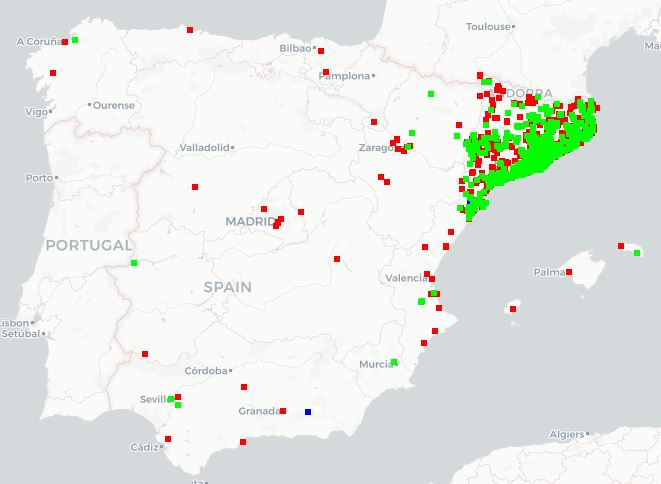

In [100]:
Image(filename=p + 'png/España.JPG',width=400, height=400)

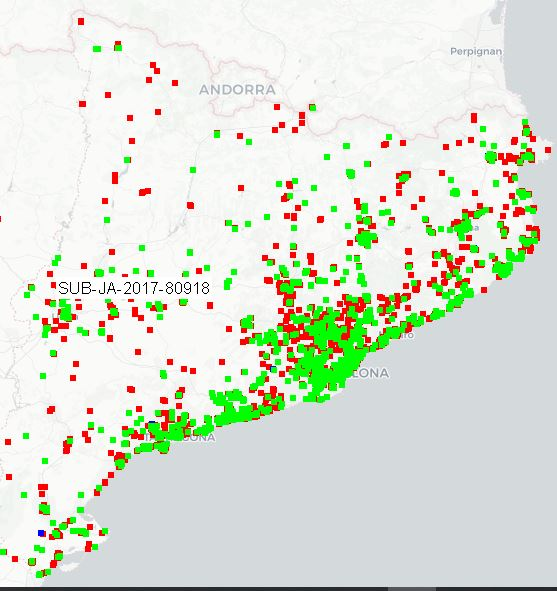

In [101]:
Image(filename=p + 'png/Catalunya.JPG',width=400, height=400)

En el siguiente mapa se muestra la concentración de pisos subastados en el area de Barcelona. Se observa claramente que están principalmente en Las zonas más deprimidas, estando el centro de Barcelona sin casi subastas a excepción del Raval.

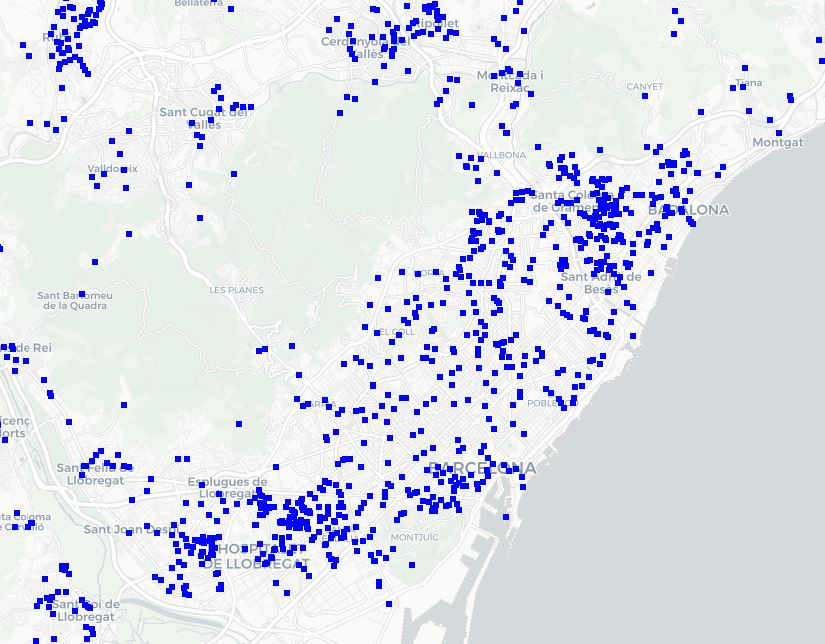

In [103]:
Image(filename=p + 'png/Area_bcn.JPG',width=400, height=400)

Lo mismo ocurre en Girona con la ciudad de La Salud. Se observa una gran concentración de pisos subastados en La Salud, mientras que en Girona ciudad son escasos.

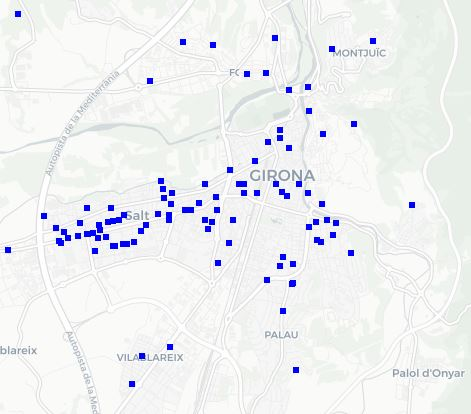

In [104]:
Image(filename=p + 'png/Girona.JPG',width=400, height=400)

Analizamos la correlación entre el valor de tasación y el importe de la puja máxima.

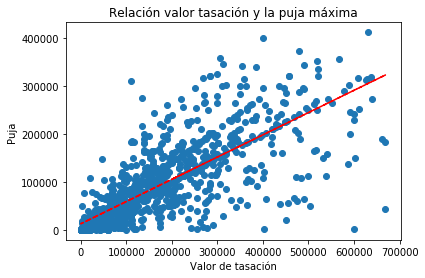

In [175]:
# cleanData = bdFinal['Valor de tasación']> bdFinal['Valor de tasación'].quantile(0.95)
cleanData = (bdFinal['Puja']>0) & (bdFinal['Puja']< bdFinal['Puja'].quantile(0.99))&(bdFinal['Valor de tasación']< bdFinal['Valor de tasación'].quantile(0.95))



X=bdFinal[cleanData]['Valor de tasación']
Y=bdFinal[cleanData]['Puja']
plt.scatter(X,Y)

z = np.polyfit(X,Y, 1)
p = np.poly1d(z)
plt.plot(X,p(X),"r--")

plt.xlabel('Valor de tasación')
plt.ylabel('Puja')
plt.title("Relación valor tasación y la puja máxima")

plt.show()

Analizamos cada uno de los factores para los que el TTest indicaba que la media era significativamente diferentes.
* Provincia iguala Barcelona: De todos los factores es el menos significativa.

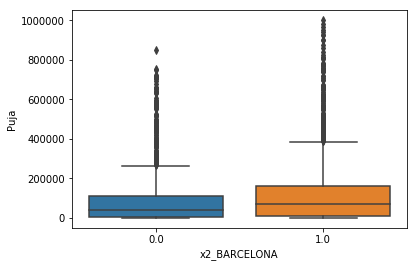

In [158]:
ax = sns.boxplot(x='x2_BARCELONA', y="Puja", data=bdFinal.loc[bdFinal['Puja']>0], dodge=False)

* Tipo de subasta __judicial en via de apremio__. Más del 50% de los valores de esta cateoría están por encima del quartil 75% del resto.

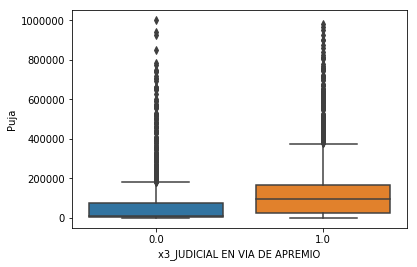

In [155]:
ax = sns.boxplot(x='x3_JUDICIAL EN VIA DE APREMIO', y="Puja", data=bdFinal.loc[bdFinal['Puja']>0], dodge=False)

* Tipo de entidad encargada de la subasta iguala Juzgado de 1º instancia. En este caso se puede apreciar como el total de los casos de este segmento tienen un importe superior a la media del otro.

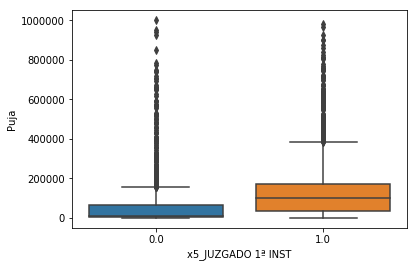

In [154]:
ax = sns.boxplot(x='x5_JUZGADO 1ª INST', y="Puja", data=bdFinal.loc[bdFinal['Puja']>0], dodge=False)

* Vivienda habitual. Este factor indica que las viviendas habituales reciben mejores ofertas que las secundarias.

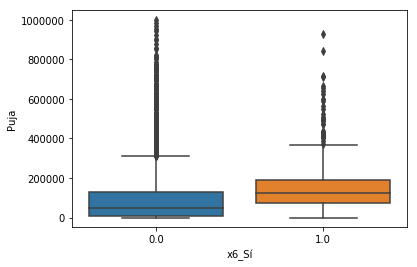

In [162]:
ax = sns.boxplot(x='x6_Sí', y="Puja", data=bdFinal.loc[bdFinal['Puja']>0], dodge=False)

### _6. Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?_


Los objetivos propuestos eran:
    
* Conocer donde está localizados los bienes subastados.

Se ha podido visualizar como los inmuebles subastados están situados principalmente en aquellas zonas geográficas con menos recueros. Para poder confirmar esta afirmación sería necesario extraer datos a nivel población o código postal de las renta media para posteriormente hacer una prueba de hipótesis.
Por consiguiente, podemos decir que no se ha podido responder del todo a la pregunta planteada.

* Conocer precio de venta y los factores que más impactan en el mismo.

Se han podido identificar los factores que más impactan en la puja máxima de una subasta y se ha hecho un modelo simple con el que poder estimar el importe.
Se puede concluir que el procedimiento de la subasta (tipo de juzgado y tipo de subasta) afecta mucho al precio oferta final, tanto como el valor de tasación.

Guardamos el fichero con los campos arreglados.

In [161]:
bdFinal.to_csv(p+"csv/bbdd_post_DataCleaning.csv")

|Contribuciones| Firma |
|---|---|
|Investigación previa| Ander Estebanez Centeno|
|Redacción de las respuestas| Ander Estebanez Centeno|
|Desarrollo código| Ander Estebanez Centeno|